# นำเข้า library ต่าง ๆ ที่ใช้สำหรับการวิเคราะห์ข้อมูล

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.base import clone

# โหลดข้อมูล โดยอัพโหลดจากคอมพิวเตอร์และตรวจสอบข้อมูลใน 5 แถวแรก

In [2]:
# โหลดข้อมูล
file_path = "../ev_journeys.csv"
df = pd.read_csv(file_path)
df.head()

,google_map_km,google_map_estimate_time,battery_percent_before,drivable_km_before,total_km_before,temperature_before,timestamp_before,date_before,battery_percent_after,drivable_km_after,total_km_after,temperature_after,timestamp_after,date_after
0,4.8,6,57,57,2767,28,08:34,2025-02-17,56,255,2772,29,08:44,2025-02-17
1,15.0,26,55,248,2776,33,19:07,2025-02-17,51,229,2791,32,19:32,2025-02-17
2,5.5,10,51,228,2791,28,08:40,2025-02-18,50,224,2796,27,08:53,2025-02-18
3,6.0,18,50,224,2797,33,17:51,2025-02-18,48,215,2803,35,18:12,2025-02-18
4,2.1,4,43,189,2825,31,20:36,2025-02-18,43,187,2828,31,20:42,2025-02-18


# ตรวจสอบประเภทของข้อมูล

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   google_map_km             46 non-null     float64
 1   google_map_estimate_time  46 non-null     int64  
 2   battery_percent_before    46 non-null     int64  
 3   drivable_km_before        46 non-null     int64  
 4   total_km_before           46 non-null     int64  
 5   temperature_before        46 non-null     int64  
 6   timestamp_before          46 non-null     object 
 7   date_before               46 non-null     object 
 8   battery_percent_after     46 non-null     int64  
 9   drivable_km_after         46 non-null     int64  
 10  total_km_after            46 non-null     int64  
 11  temperature_after         46 non-null     int64  
 12  timestamp_after           46 non-null     object 
 13  date_after                46 non-null     object 
dtypes: float64(1

# กรองข้อมูลตามเงื่อนไข โดยกรองข้อมูลที่ทำให้เกิดข้อผิดพลาด

In [4]:

rows_before = len(df)
print(f"จำนวนแถวเริ่มต้น: {rows_before}")

# --- โค้ดสำหรับกรองตามเงื่อนไขทั้งสอง ---

# 1. กำหนดเงื่อนไขที่ 1: drivable_km_before ต้องมากกว่า drivable_km_after
#    (หมายเหตุ: ถ้าคุณคิดว่ากรณีเท่ากัน (=) ก็ยอมรับได้ ให้เปลี่ยน > เป็น >=)
condition_drivable = df['drivable_km_before'] > df['drivable_km_after']

# 2. กำหนดเงื่อนไขที่ 2: total_km_before ต้องน้อยกว่า total_km_after
condition_total_km = df['total_km_before'] < df['total_km_after']

# 3. รวมเงื่อนไขทั้งสองเข้าด้วยกัน: ทั้งสองเงื่อนไขต้องเป็นจริง (ใช้ตัวดำเนินการ &)
#    สำคัญ: ต้องใส่วงเล็บรอบแต่ละเงื่อนไข!
combined_condition = (condition_drivable) & (condition_total_km)

# 4. สร้าง DataFrame ใหม่โดยกรองจาก df เดิมด้วยเงื่อนไขรวม
#    ใช้ .copy() เพื่อป้องกัน Warning และให้แน่ใจว่าเป็น DataFrame ใหม่จริงๆ
df_cleaned_strict = df[combined_condition].copy()


# แสดงผลลัพธ์
rows_after = len(df_cleaned_strict)
print(f"จำนวนแถวหลังกรองตามเงื่อนไขทั้งสอง: {rows_after}")
print(f"จำนวนแถวที่ถูกลบออก: {rows_before - rows_after}")

# แสดงข้อมูล 5 แถวแรกของ DataFrame ที่กรองแล้ว
print("\nข้อมูล 5 แถวแรกหลังกรองตามเงื่อนไข:")
print(df_cleaned_strict.head())


จำนวนแถวเริ่มต้น: 46
จำนวนแถวหลังกรองตามเงื่อนไขทั้งสอง: 44
จำนวนแถวที่ถูกลบออก: 2

ข้อมูล 5 แถวแรกหลังกรองตามเงื่อนไข:
   google_map_km  google_map_estimate_time  battery_percent_before  \
1           15.0                        26                      55   
2            5.5                        10                      51   
3            6.0                        18                      50   
4            2.1                         4                      43   
5            5.5                         9                      43   

   drivable_km_before  total_km_before  temperature_before timestamp_before  \
1                 248             2776                  33            19:07   
2                 228             2791                  28            08:40   
3                 224             2797                  33            17:51   
4                 189             2825                  31            20:36   
5                 187             2828                  28      

# คืนข้อมูลที่กรองแล้วใส่ตัวแปรเดิม

In [5]:
df = df_cleaned_strict

# สร้าง Feature เป้าหมาย และคัดเลือก Features ที่ไม่ได้ใช้ออก

In [6]:

# ลบแถวที่มีค่า missing
df = df.dropna(subset=["date_before", "timestamp_before", "date_after", "timestamp_after"])

# แปลงเป็น datetime และรองรับ timezone
df["start_time"] = pd.to_datetime(df["date_before"] + " " + df["timestamp_before"], errors='coerce', utc=True)
df["end_time"] = pd.to_datetime(df["date_after"] + " " + df["timestamp_after"], errors='coerce', utc=True)

#ลบค่าที่ผิดพลาด
df = df.dropna(subset=["start_time", "end_time"])

# คำนวณ actual_drive_time (หน่วย: นาที) และตัดค่าติดลบออก
df["actual_drive_time"] = (df["end_time"] - df["start_time"]).dt.total_seconds() / 60
df = df[df["actual_drive_time"] >= 0]
df = df.drop(columns=['battery_percent_after'])
df = df.drop(columns=['drivable_km_after'])
df = df.drop(columns=['total_km_after'])
df = df.drop(columns=['temperature_after'])
df = df.drop(columns=["date_before", "date_after", "timestamp_after","timestamp_before"])
df = df.drop(columns=["start_time", "end_time"])


# ตรวจสอบข้อมูลหลังจากการกรองข้อมูลแล้ว จะเหลือเพีงแค่ Features ที่จะใช้ train เท่านั้น

In [7]:
df.head()

,google_map_km,google_map_estimate_time,battery_percent_before,drivable_km_before,total_km_before,temperature_before,actual_drive_time
1,15.0,26,55,248,2776,33,25.0
2,5.5,10,51,228,2791,28,13.0
3,6.0,18,50,224,2797,33,21.0
4,2.1,4,43,189,2825,31,6.0
5,5.5,9,43,187,2828,28,14.0


# สร้าง Correlation Matrix เพื่อดูความสัมพันธ์ของ Features อื่นๆ กับ Feature เป้าหมาย

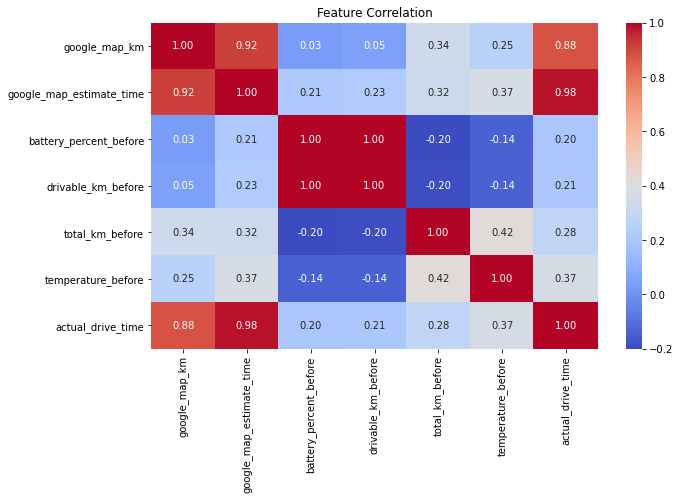

In [8]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation")
plt.show()

# ใช้ฟังก์ชัน แสดงกราฟ Bar Chart ของ Top Features ที่สัมพันธ์กับ Target

🔹 Features ที่เลือก: ['google_map_estimate_time', 'google_map_km']


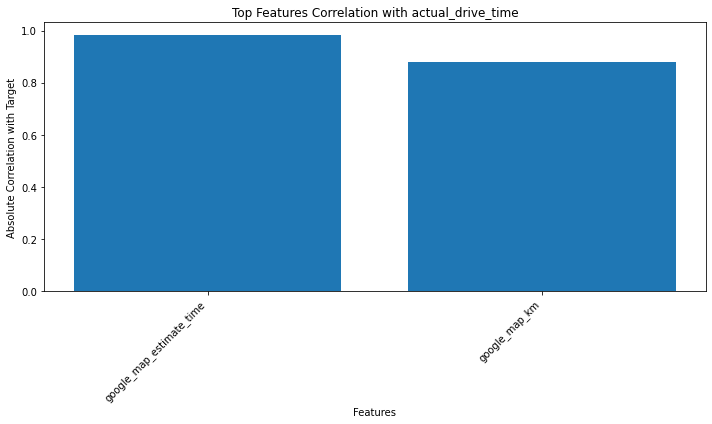

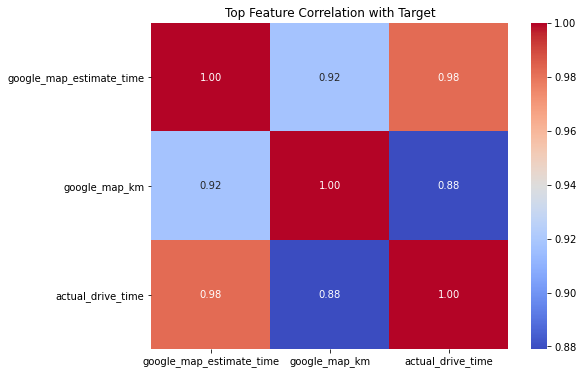

In [9]:
def plot_top_features_correlation(corr_target, top_features, target):
    """สร้าง Bar Chart แสดงค่า Correlation ของ Top Features กับ Target Variable"""
    plt.figure(figsize=(10, 6))
    corr_values = corr_target[top_features]
    plt.bar(top_features, corr_values)
    plt.xlabel("Features")
    plt.ylabel("Absolute Correlation with Target")
    plt.title(f"Top Features Correlation with {target}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# เรียกใช้ Function ใน Main Program (หลังจากเลือก Top Features)
if __name__ == "__main__":
    # ... (Code ส่วนอื่นๆ) ...

    # 5. เลือกฟีเจอร์ที่มี Correlation สูงสุดกับ Target
    target ='actual_drive_time'
    corr_target = corr_matrix[target].drop(target).abs()
    top_features = corr_target.nlargest(2).index.tolist()
    print("🔹 Features ที่เลือก:", top_features)

    # เพิ่มการเรียกใช้ Function สำหรับ Visualization
    plot_top_features_correlation(corr_target, top_features, target)

    # 6. แสดง Heatmap ของฟีเจอร์ที่เลือก
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df[top_features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Top Feature Correlation with Target")
    plt.show()

# เตรียม Model สำหรับ Train/test ชุดข้อมูล


In [10]:
# แยก feature และ target
X_train = df[top_features]
y_train = df['actual_drive_time']

# สร้างและฝึกโมเดล Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)




LinearRegression()

In [11]:
import joblib
joblib.dump(model, "actual_time_drive_model.joblib")

['actual_time_drive_model.joblib']